# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import json
from scipy.stats import pearsonr
import copy

# Parameters

In [2]:
# use the 'works as' template or not
works_as = False

# for prior calculation, shared for bert and roberta
if works_as:
    prior_string_contained = 'works as a '
    save_template = 'worksas'
else:
    prior_string_contained = 'is a '
    save_template = 'is'

# the start of the plateau
k_bert = 18 # should be 18 (alternatively 24)
k_roberta = 36 # should be 36 (alternatively 49)

# save path
fig_root = '/content/drive/MyDrive/checkpoint-bias/figures'

# Utils

In [3]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html

def scatter_hist(x, y, color, xhist = True):
    fig = plt.figure(dpi=150, figsize=(6,6))

    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)

    ax = fig.add_subplot(gs[1, 0])
    if xhist:
        ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    # no labels
    if xhist:
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histx.tick_params(axis="y", labelleft=False, tick1On=False)

    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False, tick1On=False)

    # the scatter plot:
    ax.grid(b=True, which='major', color='grey')

    ax.scatter(x, y, s=1, c = color)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_aspect(1)

    # now determine nice limits by hand:
    binwidth = 0.025
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)

    if xhist:
        ax_histx.grid(b=True, which='major', axis='x', color='grey')
        ax_histx.hist(x, bins=bins, color = color)
    
    ax_histy.grid(b=True, which='major', axis='y', color='grey')
    ax_histy.hist(y, bins=bins, orientation='horizontal', color = color)

    return fig, ax

# Calculation

In [4]:
# list of variables

# R_roberta: matrix, roberta ratios
# N_roberta: matrix, roberta normalized ratios
# C_roberta: matrix, roberta certainties

# c_roberta_vec: vector of certainty
# R_roberta_partial: take only rows below k from R_roberta
# v_roberta_R_vec: vector of CV, roberta, unnormalized
# r_roberta_vec: vector of averaged ratio, roberta, unnormalized
# N_roberta_partial: take only rows below k from N_roberta
# v_roberta_N_vec: vector of CV, roberta, normalized
# n_roberta_vec: vector of averaged ratio, roberta, normalized

# v_roberta_prior: a value, CV of the prior ratio, roberta
# c_roberta_prior: a value, certainty of the prior, roberta

# R_berts: list of matrices, bert ratios
# N_berts: list of matrices, bert normalized ratios
# C_berts: list of matrices, bert certainties
# v_berts_vec: list of vectors of CV, bert

# s_bert: 29, number of available checkpoints, bert
# s_roberta: 62, number of available checkpoints, roberta

# s_vec: vector, yearly size of corpus
# f_vec: vector, frequency of all professions
# y_t_vec: vector, frequencies from 1700 to 2000 of one profession

In [5]:
# number of rows of the matrices
s_bert = 29
s_roberta = 62

# bert seeds
seeds = [0, 1, 2, 3, 4]

## Shared

In [6]:
# read in all professions

prof923a = []

with open('/content/drive/MyDrive/checkpoint-bias/data/923-professions.txt', 'r') as f:
    for line in f:
      prof923a.append(line.strip('\n'))

In [7]:
# read in the total word count in the BookCorpus from 1700 to 2000
s_vec = []

with open('/content/drive/MyDrive/checkpoint-bias/data/2000-1700-total.txt', 'r') as f:
    for line in f:
        s_vec.append(int(line.strip('\n')))

# should be 301
print(len(s_vec))

s_vec = [s_vec[-(i+1)] for i in range(len(s_vec))]

# smaller
print(s_vec[0])

# larger
print(s_vec[-1])

# convert into numpy array for direct multiplication
s_vec = np.array(s_vec)

301
1153897
8184220292


In [8]:
# read in frequencies of all professions
# 520 is from 1500 to 2019
# index 0 is 1500
# index 200 is 1700
# index 500 is 2000

# number of occurrences
f_vec = []

with open('/content/drive/MyDrive/checkpoint-bias/data/ngram-freqs.jsonl', 'r') as f:
    for line in f:
        try:
            # read in 520 frequencies, case-insensitive is in 0
            freqs = json.loads(line.replace('\'', '\"'))[0]['timeseries']
        except:
            # ngram not in corpus
            freqs = [0 for _ in range(520)]
        
        y_t_vec = np.array(freqs[200:501])
        
        f_t = np.inner(y_t_vec, s_vec)

        f_vec.append(f_t)

# convert into an array for sorting
f_vec = np.array(f_vec)

# indices of professions with the highest/lowest total count
# the array is NOT sorted in place
top_indices = f_vec.argsort()[-20:][::-1]
bottom_indices = f_vec.argsort()[:20][::-1]

# can compare this with a visualization in the ngram viewer
print('Most frequent professions (case-insensitive):')
for i in top_indices:
    print(prof923a[i], f_vec[i])

print()

print('Least frequent professions (case-insensitive):')
for i in bottom_indices:
    print(prof923a[i], f_vec[i])

# normalized, for plotting
f_vec_normalized = f_vec / np.max(f_vec)

Most frequent professions (case-insensitive):
a president 74478455.76790582
a secretary 56497400.267797895
a model 39430690.548720166
an author 30901456.497421943
a minister 28679353.997304212
a judge 27363138.781518694
an official 22718691.520772032
a professor 22678873.829151746
an assistant 21025113.595525395
a governor 20526576.686924744
a police 20504788.09674695
a teacher 17991033.22086358
a commissioner 16927286.49105036
a clerk 15882236.467726478
a guide 15162930.120365668
an engineer 13054921.928385345
a writer 12214450.664830009
a treasurer 10469360.61632301
a superintendent 9917875.039951883
a miller 9532845.210512422

Least frequent professions (case-insensitive):
a demographic marketer 0.0
a chief gaming officer 0.0
a dtp artist 0.0
an ambulatist 0.0
an online streamer 0.0
a webcam model 0.0
a software quality assurance analyst 0.0
a scientific equipment optician 0.0
a chief visibility officer 0.0
a swimming pool service technician 0.0
a limited radiology technician 0.0
a 

In [9]:
# number of lower-case occurrences
f_vec_lower = []

with open('/content/drive/MyDrive/checkpoint-bias/data/ngram-freqs.jsonl', 'r') as f:
    for line in f:
        j = json.loads(line.replace('\'', '\"'))

        freqs_lower = []

        if len(j):
            flag = 0
            for entry in j:
                if entry['ngram'].islower():
                    flag += 1
                    freqs_lower = entry['timeseries']

        if not freqs_lower:
            # lowercase ngram not in corpus
            freqs_lower = [0 for _ in range(520)]

        y_t_vec_lower = np.array(freqs_lower[200:501])
        
        f_t_lower = np.inner(y_t_vec_lower, s_vec)

        f_vec_lower.append(f_t_lower)

# convert into an array for sorting
f_vec_lower = np.array(f_vec_lower)

# indices of professions with the highest/lowest total count
# the array is NOT sorted in place
top_indices = f_vec_lower.argsort()[-20:][::-1]
bottom_indices = f_vec_lower.argsort()[:20][::-1]

# can compare this with a visualization in the ngram viewer
print('Most frequent professions (lowercase):')
for i in top_indices:
    print(prof923a[i], f_vec_lower[i])

print()

print('Least frequent professions (lowercase):')
for i in bottom_indices:
    print(prof923a[i], f_vec_lower[i])

# normalized, for plotting
f_vec_lower_normalized = f_vec_lower / np.max(f_vec_lower)

Most frequent professions (lowercase):
a model 32480312.10136372
an author 25040406.839890808
an official 18042686.359476563
a president 17563932.221749395
a judge 16172926.490918912
a police 14748976.612632265
a teacher 14271030.06896962
a writer 11572171.121988378
a secretary 9771005.158786818
a guide 9729225.091375666
a clerk 8739160.949773502
a minister 7654604.197926272
a physician 7303920.713271047
an assistant 7286619.8600134
an engineer 7219937.241526585
a host 6764905.274839365
a governor 6245260.80002532
a farmer 6106872.584956197
an artist 5887422.983253839
a pilot 5133767.505878852

Least frequent professions (lowercase):
a chief genealogical officer 0.0
a chief analytics officer 0.0
a medical practice consultant 0.0
a primary spine practitioner 0.0
a mental health care navigator 0.0
a swimming pool service technician 0.0
a builder broker 0.0
a website content writer 0.0
a gamekeepers in the united kingdom 0.0
a communicative disorders assistant 0.0
a ceo of public schools 

## RoBERTa

In [10]:
# matrices for roberta

# read in all priors
priors = pd.read_pickle('/content/drive/MyDrive/checkpoint-bias/data/roberta-prior.pkl')

# read in all scores
scores = pd.read_pickle('/content/drive/MyDrive/checkpoint-bias/data/roberta-professions.pkl')

# ratios
R_roberta = []

# normalized ratios
N_roberta = []

# certainties
C_roberta = []

# use different substring to filter prior templates
# not necessarily depend on the article choice of profa

prior_he_scores = priors[
    (priors['pronoun'] == 'He') &
    (priors['seed'] == 0) &
    (priors['template'].str.contains(prior_string_contained))
]['score'].to_numpy()

prior_she_scores = priors[
    (priors['pronoun'] == 'She') &
    (priors['seed'] == 0) &
    (priors['template'].str.contains(prior_string_contained))
]['score'].to_numpy()

c_roberta_prior = np.mean(prior_he_scores[k_roberta:] + prior_she_scores[k_roberta:])
partial_prior = prior_he_scores[k_roberta:] / prior_she_scores[k_roberta:]
v_roberta_prior = np.std(partial_prior) / np.mean(partial_prior)

# save for plotting purpose, roberta only!
roberta_prior_he_scores = prior_he_scores
roberta_prior_she_scores = prior_she_scores

# loop over all professions
# this takes roughly 1.5 minutes
# the substring filtering method (.str.contains()) is too slow
# use numpy indexing instead
for profa in tqdm(prof923a):

    if works_as:
        he_scores = scores[
            (scores['pronoun'] == 'He') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[1::2] # take only even indices, the 'works as' template

        she_scores = scores[
            (scores['pronoun'] == 'She') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[1::2]
    else:
        he_scores = scores[
            (scores['pronoun'] == 'He') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[::2] # take only odd indices, the 'is' template

        she_scores = scores[
            (scores['pronoun'] == 'She') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[::2]

    R_roberta.append(he_scores / she_scores)
    N_roberta.append(he_scores / she_scores * prior_she_scores / prior_he_scores)
    C_roberta.append(he_scores + she_scores)

# convert to array and transpose, consistent with paper notation
R_roberta = np.transpose(np.array(R_roberta))
N_roberta = np.transpose(np.array(N_roberta))
C_roberta = np.transpose(np.array(C_roberta))

# check the shape
print(R_roberta.shape, N_roberta.shape, C_roberta.shape)

100%|██████████| 923/923 [01:39<00:00,  9.25it/s]

(62, 923) (62, 923) (62, 923)


In [11]:
c_roberta_vec = np.mean(C_roberta[k_roberta:,:], axis = 0)

# unnormalized
R_roberta_partial = R_roberta[k_roberta:,:]
v_roberta_R_vec = np.std(R_roberta_partial, axis = 0)/np.mean(R_roberta_partial, axis = 0)
r_roberta_vec = np.mean(R_roberta_partial, axis = 0)

# normalized
N_roberta_partial = N_roberta[k_roberta:,:]
v_roberta_N_vec = np.std(N_roberta_partial, axis = 0)/np.mean(N_roberta_partial, axis = 0)
n_roberta_vec = np.mean(N_roberta_partial, axis = 0)

# check shape
print(c_roberta_vec.shape,
      v_roberta_R_vec.shape, v_roberta_N_vec.shape,
      r_roberta_vec.shape, n_roberta_vec.shape)

(923,) (923,) (923,) (923,) (923,)


## BERT

In [12]:
# matrices for bert

# read in all priors, this contains all seeds
priors = pd.read_pickle('/content/drive/MyDrive/checkpoint-bias/data/bert-prior.pkl')

# ratios, all seeds
R_berts = []

# normalized ratios, all seeds
N_berts = []

# certainties, all seeds
C_berts = []

# c and v of priors
c_berts_prior = []
v_berts_prior = []

for seed in seeds:

    # read in all scores, for only one seed
    scores = pd.read_pickle(f'/content/drive/MyDrive/checkpoint-bias/data/bert-professions-seed-{seed}.pkl')

    # ratios
    R_bert = []

    # normalized ratios
    N_bert = []

    # certainties
    C_bert = []

    # use different substring to filter prior templates
    # not necessarily depend on the article choice of profa
    prior_he_scores = priors[
        (priors['pronoun'] == 'he') &
        (priors['seed'] == seed) & # use seed here!
        (priors['template'].str.contains(prior_string_contained))
    ]['score'].to_numpy()

    prior_she_scores = priors[
        (priors['pronoun'] == 'she') &
        (priors['seed'] == seed) & # use seed here!
        (priors['template'].str.contains(prior_string_contained))
    ]['score'].to_numpy()

    # calculate v and c for the prior
    c_bert_prior = np.mean(prior_he_scores[k_bert:] + prior_she_scores[k_bert:])
    partial_prior = prior_he_scores[k_bert:] / prior_she_scores[k_bert:]
    v_bert_prior = np.std(partial_prior) / np.mean(partial_prior)

    # save
    c_berts_prior.append(c_bert_prior)
    v_berts_prior.append(v_bert_prior)

    # loop over all professions
    for profa in tqdm(prof923a):

        if works_as:
            he_scores = scores[
                (scores['pronoun'] == 'he') &
                (scores['occupation'] == profa) &
                (scores['seed'] == seed)
            ]['score'].to_numpy()[1::2] # take only even indices, the 'works as' template

            she_scores = scores[
                (scores['pronoun'] == 'she') &
                (scores['occupation'] == profa) &
                (scores['seed'] == seed)
            ]['score'].to_numpy()[1::2]
        else:
            he_scores = scores[
                (scores['pronoun'] == 'he') &
                (scores['occupation'] == profa) &
                (scores['seed'] == seed)
            ]['score'].to_numpy()[::2] # take only odd indices, the 'is' template

            she_scores = scores[
                (scores['pronoun'] == 'she') &
                (scores['occupation'] == profa) &
                (scores['seed'] == seed)
            ]['score'].to_numpy()[::2]


        R_bert.append(he_scores / she_scores)
        N_bert.append(he_scores / she_scores * prior_she_scores / prior_he_scores)
        C_bert.append(he_scores + she_scores)

    # convert to array and transpose, consistent with paper notation
    R_bert = np.transpose(np.array(R_bert))
    N_bert = np.transpose(np.array(N_bert))
    C_bert = np.transpose(np.array(C_bert))

    # check the shape
    print(R_bert.shape, N_bert.shape, C_bert.shape)

    # save
    R_berts.append(R_bert)
    N_berts.append(N_bert)
    C_berts.append(C_bert)

100%|██████████| 923/923 [00:45<00:00, 20.34it/s]


(29, 923) (29, 923) (29, 923)


100%|██████████| 923/923 [00:45<00:00, 20.32it/s]


(29, 923) (29, 923) (29, 923)


100%|██████████| 923/923 [00:45<00:00, 20.23it/s]


(29, 923) (29, 923) (29, 923)


100%|██████████| 923/923 [00:47<00:00, 19.39it/s]


(29, 923) (29, 923) (29, 923)


100%|██████████| 923/923 [00:45<00:00, 20.22it/s]

(29, 923) (29, 923) (29, 923)


In [13]:
# rerun this cell if k_bert has been changed

c_berts_vec = []
v_berts_R_vec = []
r_berts_vec = []
v_berts_N_vec = []
n_berts_vec = []

for seed in seeds:
    R_bert = R_berts[seed]
    N_bert = N_berts[seed]
    C_bert = C_berts[seed]

    c_bert_vec = np.mean(C_bert[k_bert:,:], axis = 0)
    c_berts_vec.append(c_bert_vec)

    # unnormalized
    R_bert_partial = R_bert[k_bert:,:]
    v_bert_R_vec = np.std(R_bert_partial, axis = 0)/np.mean(R_bert_partial, axis = 0)
    r_bert_vec = np.mean(R_bert_partial, axis = 0)

    v_berts_R_vec.append(v_bert_R_vec)
    r_berts_vec.append(r_bert_vec)

    # normalized
    N_bert_partial = N_bert[k_bert:,:]
    v_bert_N_vec = np.std(N_bert_partial, axis = 0)/np.mean(N_bert_partial, axis = 0)
    n_bert_vec = np.mean(N_bert_partial, axis = 0)

    v_berts_N_vec.append(v_bert_N_vec)
    n_berts_vec.append(n_bert_vec)

    # check shape
    print(c_bert_vec.shape,
          v_bert_R_vec.shape, v_bert_N_vec.shape,
          r_bert_vec.shape, n_bert_vec.shape)

(923,) (923,) (923,) (923,) (923,)
(923,) (923,) (923,) (923,) (923,)
(923,) (923,) (923,) (923,) (923,)
(923,) (923,) (923,) (923,) (923,)
(923,) (923,) (923,) (923,) (923,)


# Plot

## Intro Figure

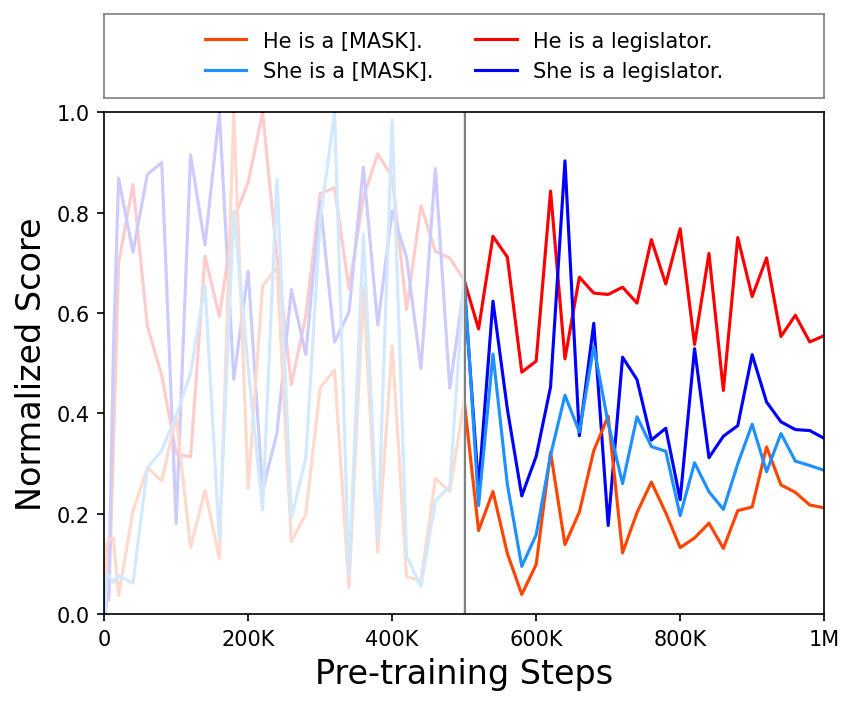

In [14]:
# fluctuations of the prior and two selected templates

# read in roberta scores AGAIN
scores = pd.read_pickle('/content/drive/MyDrive/checkpoint-bias/data/roberta-professions.pkl')

# save the checkpoint numbers, from 0 to 1,000,000 for roberta
checkpoints = []

# read in numbers
with open('/content/drive/MyDrive/roberta-checkpoints/steps.txt', 'r') as f:
    for line in f:
        checkpoints.append(int(line))

# initialize plot
fig = plt.figure(dpi=150, figsize=(6,5))

gs = fig.add_gridspec(2, 1, height_ratios=(1, 6),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])

# recalculate RoBERTa prior and two templates

for profa in prof923a[:1]:

    if works_as:
        he_scores = scores[
            (scores['pronoun'] == 'He') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[1::2] # take only even indices, the 'works as' template

        she_scores = scores[
            (scores['pronoun'] == 'She') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[1::2]
    else:
        he_scores = scores[
            (scores['pronoun'] == 'He') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[::2] # take only odd indices, the 'is' template

        she_scores = scores[
            (scores['pronoun'] == 'She') &
            (scores['occupation'] == profa) &
            (scores['seed'] == 0)
        ]['score'].to_numpy()[::2]

    # plot normalized
    ax.plot(checkpoints, he_scores / np.max(he_scores), c = 'red')
    ax.plot(checkpoints, she_scores / np.max(she_scores), c = 'blue')

ax.plot(checkpoints, roberta_prior_he_scores / np.max(roberta_prior_he_scores), c = 'orangered')
ax.plot(checkpoints, roberta_prior_she_scores / np.max(roberta_prior_she_scores), c = 'dodgerblue')

ax.set_xlim(0, 1e6)
ax.set_ylim(0,1)

ax.set_xticks([0, 2e5, 4e5, 6e5, 8e5, 1e6])
ax.set_xticklabels(['0', '200K', '400K', '600K', '800K', '1M'])

# indicate stable region
ax.axvline(x=5e5, ymin=0, ymax=1, c='grey')

# mask left region
mask = matplotlib.patches.Rectangle((1e3, 0.002), 5e5-1e3, 0.996, linewidth=0,
                                    edgecolor='none', facecolor='white',
                                    alpha=0.8,
                                    zorder=3)
ax.add_patch(mask)

ax.set_ylabel('Normalized Score', fontsize=16)
ax.set_xlabel('Pre-training Steps', fontsize=16)

# put legend, ONLY use the 'is' template

lgd = fig.add_subplot(gs[0, 0])
lgd.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
lgd.plot([],[], label = 'He is a [MASK].', c = 'orangered')
lgd.plot([],[], label = 'She is a [MASK].', c = 'dodgerblue')
lgd.plot([],[], label = 'He is a legislator.', c = 'red')
lgd.plot([],[], label = 'She is a legislator.', c = 'blue')
legend = lgd.legend(loc='center', ncol=2)
legend.get_frame().set_edgecolor('none')

for axis in ['top', 'bottom', 'left', 'right']:
    lgd.spines[axis].set_color('gray')

plt.savefig(f'{fig_root}/intro-figure-{save_template}.pdf', bbox_inches='tight')
plt.show()

## RQ1 & RQ2

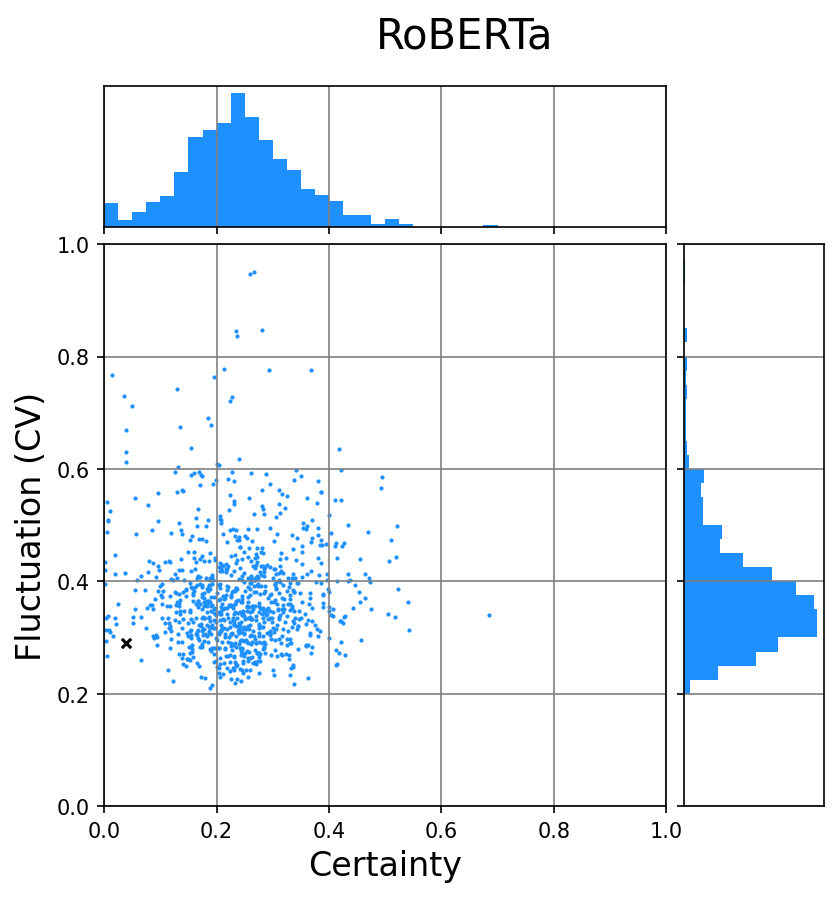

(0.0004352684970694588, 0.9894634938910566)
0.20965096257401747 0.9506917733250015


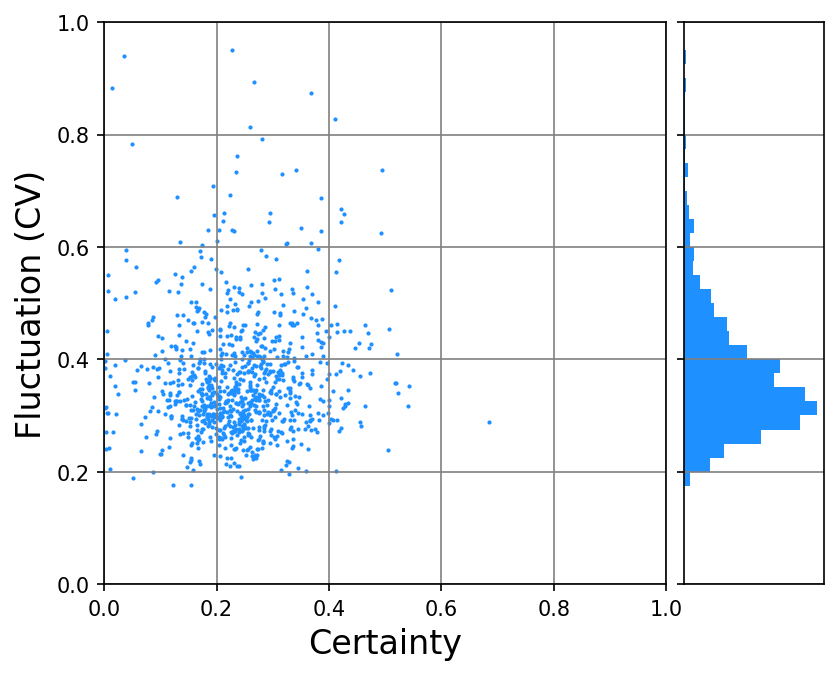

(0.055332898017292756, 0.09294306016330374)


In [15]:
# RQ1 & RQ2, roberta

# unnormalized

# no correlation between naturalness and fluctuation
fig, ax = scatter_hist(c_roberta_vec, v_roberta_R_vec, color = 'dodgerblue')

# No. We see no correlation.
# fig.suptitle('RQ1 RoBERTa unnormalized')
fig.suptitle('RoBERTa', fontsize=20)

ax.set_xlabel('Certainty', fontsize=16)
ax.set_ylabel('Fluctuation (CV)', fontsize=16)

# also show the prior
ax.scatter([c_roberta_prior], [v_roberta_prior], s=20, c = 'k', marker='x')

plt.savefig(f'{fig_root}/RQ1-roberta-{save_template}-k{k_roberta}-unnormalized.pdf', bbox_inches='tight')
plt.show()

# there should be almost no correlation
print(pearsonr(c_roberta_vec, v_roberta_R_vec))

print(min(v_roberta_R_vec), max(v_roberta_R_vec))

# normalized
fig, ax = scatter_hist(c_roberta_vec, v_roberta_N_vec, color = 'dodgerblue', xhist=False)

# sizes will fit if this is commented out!
# fig.suptitle('RQ1 RoBERTa normalized')

ax.set_xlabel('Certainty', fontsize=16)
ax.set_ylabel('Fluctuation (CV)', fontsize=16)

plt.savefig(f'{fig_root}/RQ1-roberta-{save_template}-k{k_roberta}-normalized.pdf', bbox_inches='tight')
plt.show()

print(pearsonr(c_roberta_vec, v_roberta_N_vec))

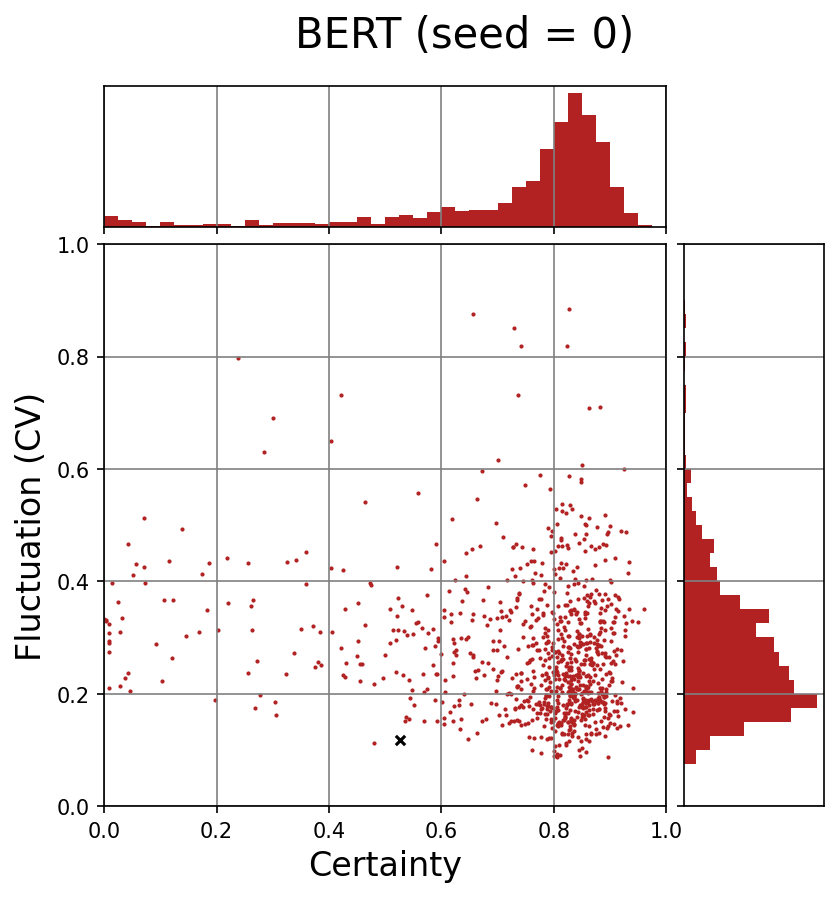

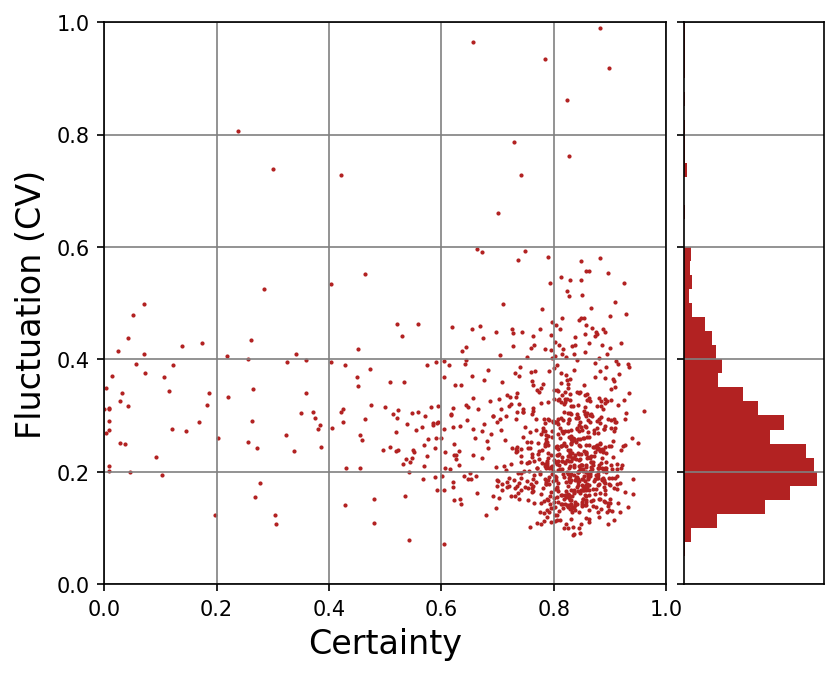

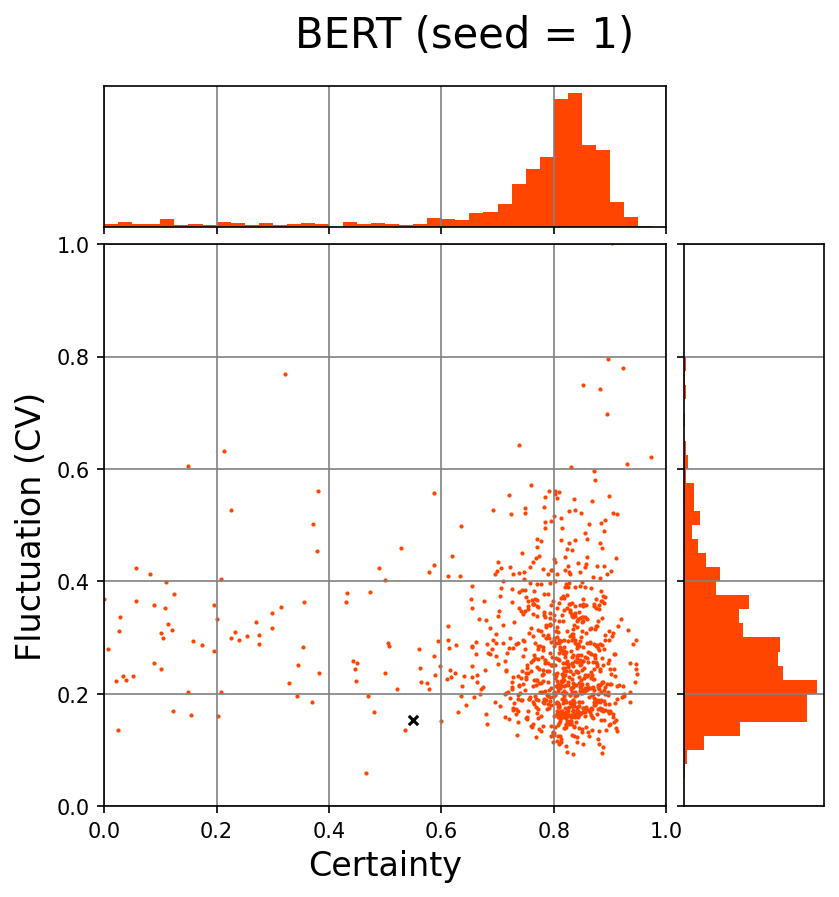

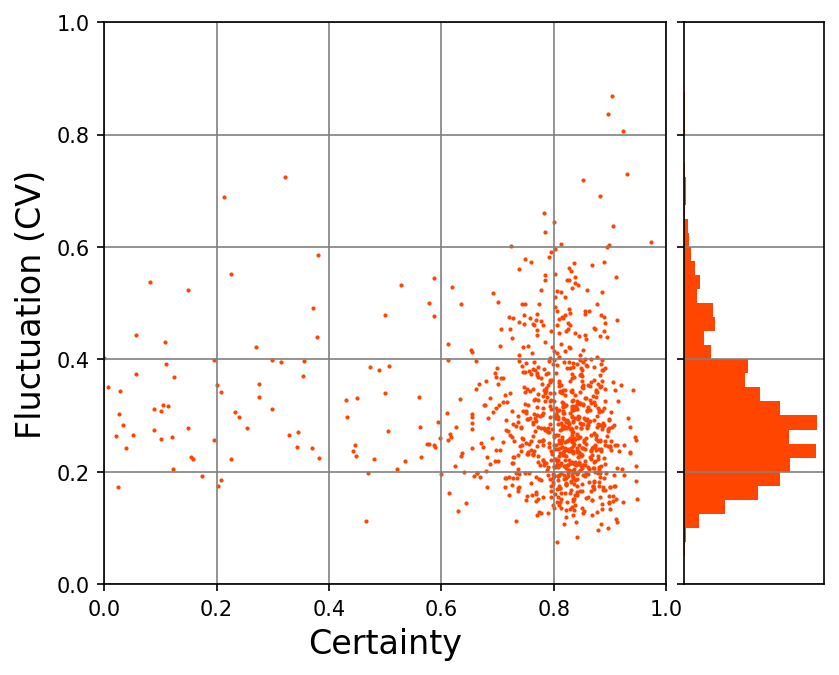

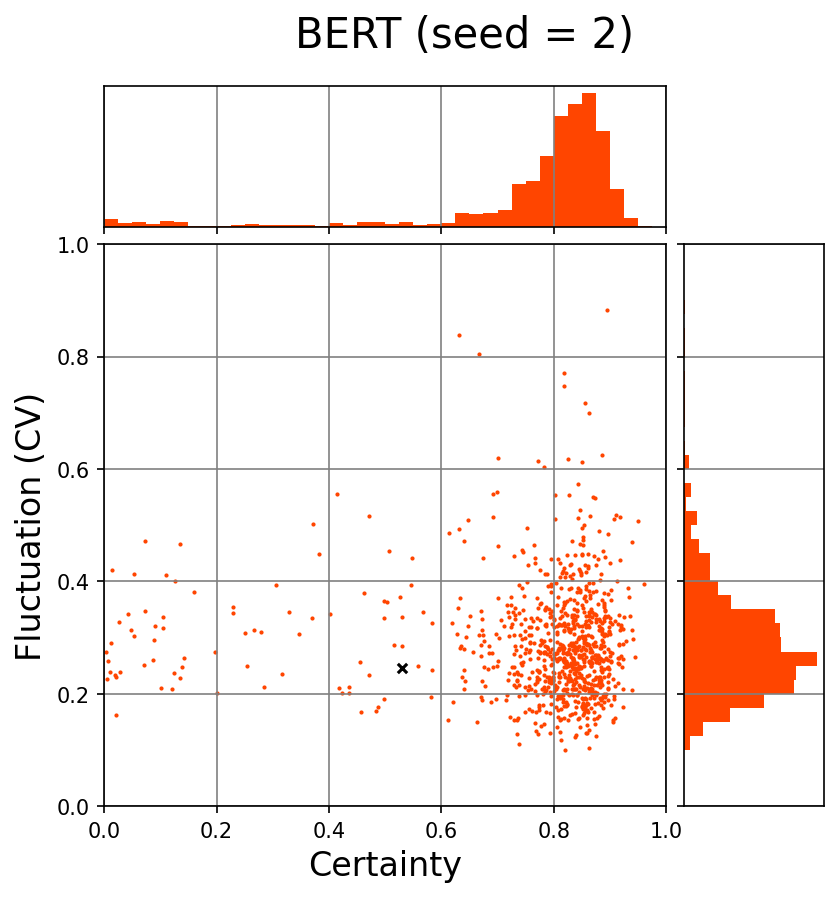

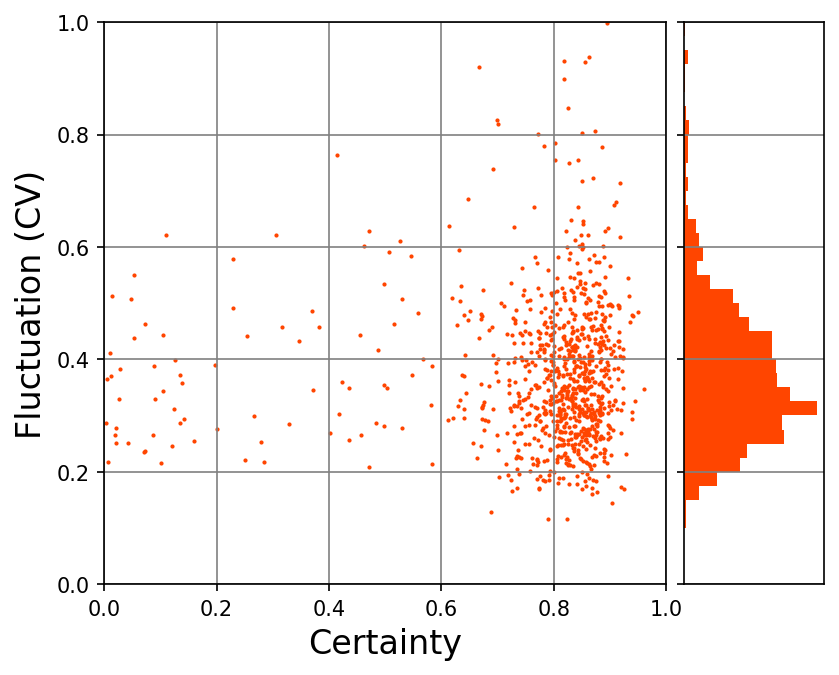

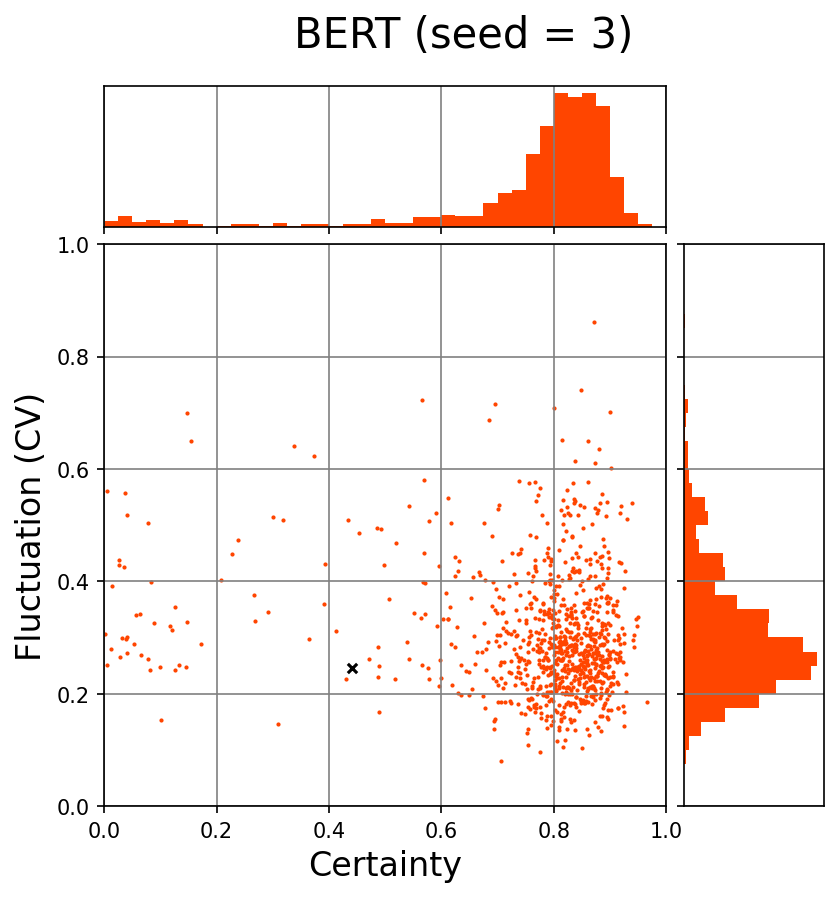

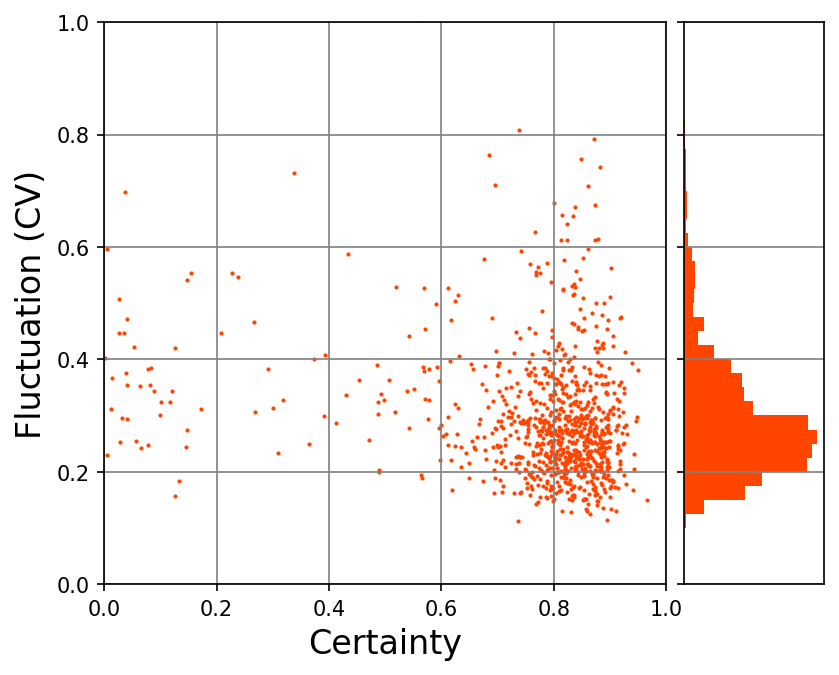

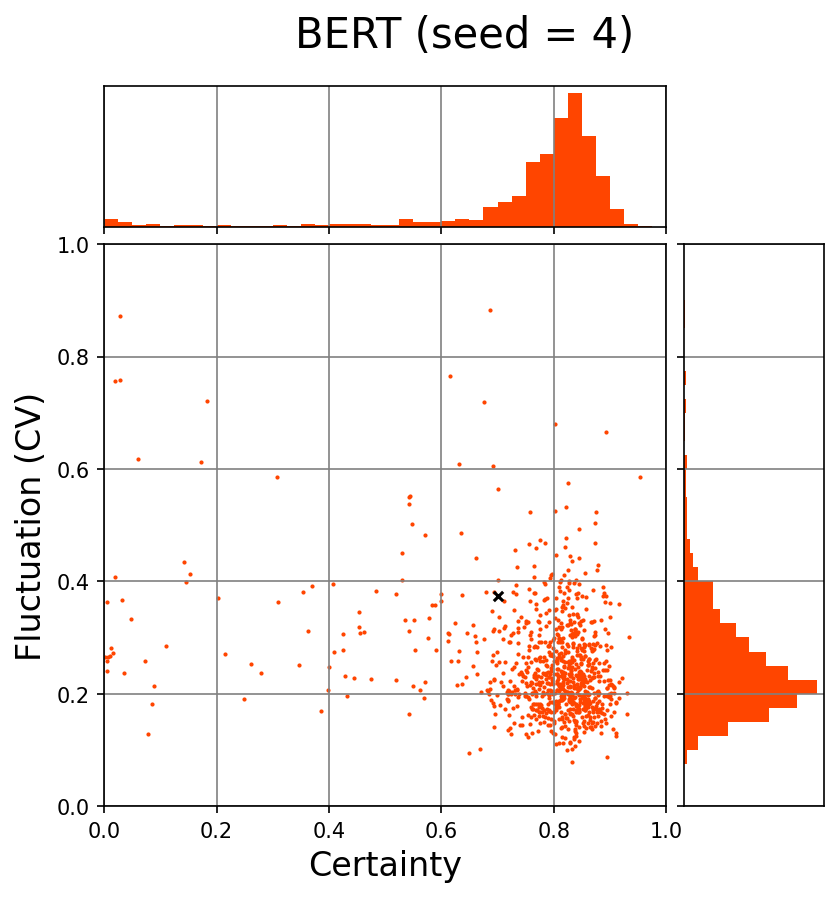

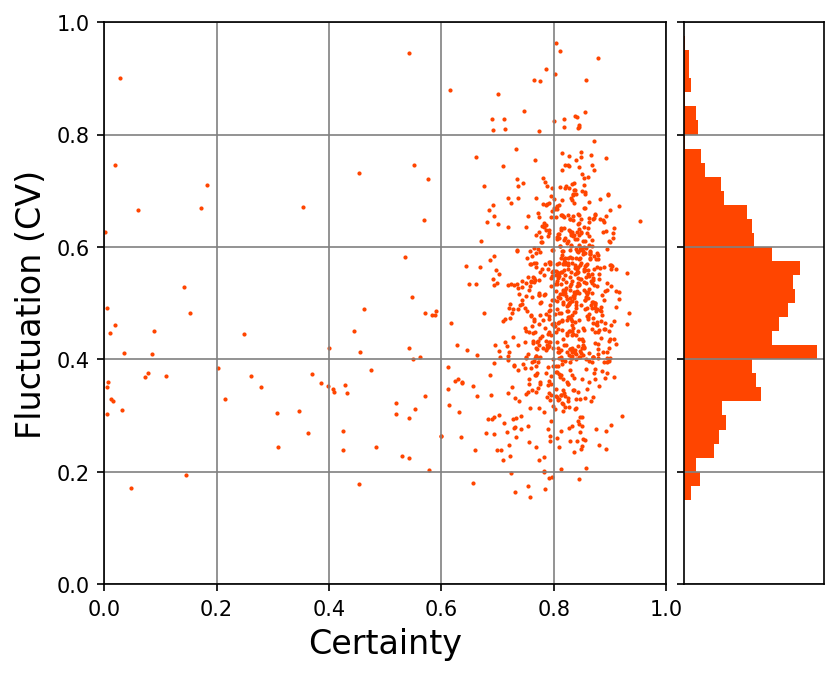

In [16]:
# RQ1 & RQ2, bert

for seed in seeds:

    if seed == 0:
       color = 'firebrick'
    else:
       color = 'orangered'

    # unnormalized

    # no correlation between naturalness and fluctuation
    fig, ax = scatter_hist(c_berts_vec[seed], v_berts_R_vec[seed], color = color)

    # No. We see no correlation.
    fig.suptitle(f'BERT (seed = {seed})', fontsize=20)

    ax.set_xlabel('Certainty', fontsize=16)
    ax.set_ylabel('Fluctuation (CV)', fontsize=16)

    # also show the prior
    ax.scatter([c_berts_prior[seed]], [v_berts_prior[seed]], s=20, c = 'k', marker='x')

    plt.savefig(f'{fig_root}/RQ1-bert-s{seed}-{save_template}-k{k_bert}-unnormalized.pdf', bbox_inches='tight')
    plt.show()


    # normalized

    # no correlation between naturalness and fluctuation
    fig, ax = scatter_hist(c_berts_vec[seed], v_berts_N_vec[seed], color = color, xhist=False)

    # No. We see no correlation.

    ax.set_xlabel('Certainty', fontsize=16)
    ax.set_ylabel('Fluctuation (CV)', fontsize=16)

    plt.savefig(f'{fig_root}/RQ1-bert-s{seed}-{save_template}-k{k_bert}-normalized.pdf', bbox_inches='tight')
    plt.show()

## RQ3

In [17]:
# RQ3, roberta, use case-sensitive (lowercase) results!
print(pearsonr(f_vec_lower_normalized, v_roberta_N_vec))
print(pearsonr(f_vec_lower_normalized, v_roberta_R_vec))

(-0.047377913127214254, 0.15036554243141187)
(0.04614348261927702, 0.16129553141161795)


In [18]:
# RQ3, bert
for seed in seeds:
    print(pearsonr(f_vec_normalized, v_berts_N_vec[seed]))
    print(pearsonr(f_vec_normalized, v_berts_R_vec[seed]))

(-0.06381249065026301, 0.05261954280561168)
(-0.08454747250438686, 0.010177160115218901)
(-0.15022053214092612, 4.5684923058268065e-06)
(-0.1141940603290721, 0.0005089615630441694)
(-0.02079615749488081, 0.5280285203950883)
(-0.03365369125325809, 0.3070963552630213)
(0.023592543365208784, 0.47405841154430195)
(-0.009973464652713525, 0.7621947894409655)
(-0.04447756436426323, 0.17698194331116182)
(-0.0443134736284929, 0.1785863941658554)


## RQ4

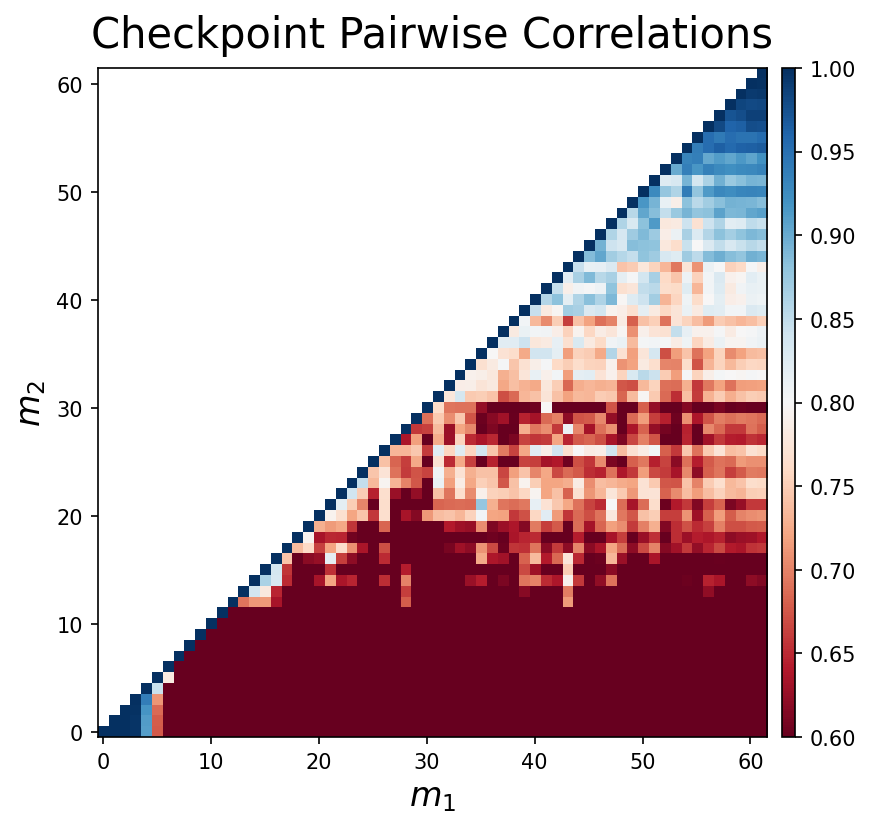

In [19]:
# RQ4, roberta

# initialize
results = np.empty((s_roberta, s_roberta))

# masking the upper triangle
results[:] = np.NaN

# get Pearson's r for each step, do not save p
for i in range(s_roberta):
    for j in range(i, s_roberta):
        results[i, j] = pearsonr(N_roberta[i], N_roberta[j])[0]
      
# plot
fig, ax = plt.subplots(figsize=(6,6), dpi=150)

cmap = copy.copy(matplotlib.cm.get_cmap("RdBu"))
cmap.set_bad('white', 1.)

heatmap = ax.imshow(results, cmap=cmap, origin='lower', vmin=0.6, vmax=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

fig.colorbar(heatmap, cax = cax)

ax.set_title(f"Checkpoint Pairwise Correlations", fontsize=20, pad=10)
ax.set_xlabel("$m_1$", fontsize=16)
ax.set_ylabel("$m_2$", fontsize=16)

plt.savefig(f'{fig_root}/RQ4-roberta-{save_template}-k{k_roberta}-normalized.pdf', bbox_inches='tight')
plt.show()

## RQ5

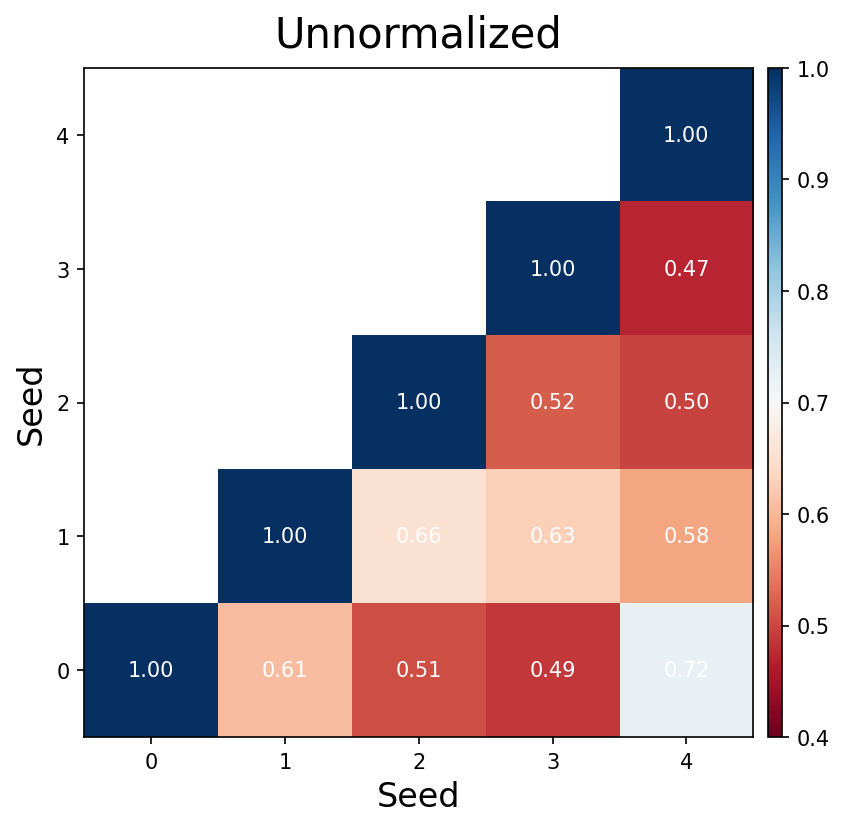

In [20]:
# RQ5, bert, unnormalized

# initialize
results = np.empty((5, 5))

# masking the upper triangle
results[:] = np.NaN

# the correlation is very low!
for i in range(5):
    for j in range(i, 5):
        results[i,j] = pearsonr(r_berts_vec[i], r_berts_vec[j])[0]

# plot
fig, ax = plt.subplots(figsize=(6,6), dpi=150)

cmap = copy.copy(matplotlib.cm.get_cmap("RdBu"))
cmap.set_bad('white', 1.)

heatmap = ax.imshow(results, cmap=cmap, origin='lower', vmin=0.4, vmax=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

fig.colorbar(heatmap, cax = cax)

# text annotation
for i in range(5):
    for j in range(i, 5):
        text = ax.text(j, i, f'{results[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_title(f"Unnormalized", fontsize=20, pad=10)
ax.set_xlabel("Seed", fontsize=16)
ax.set_ylabel("Seed", fontsize=16)

plt.savefig(f'{fig_root}/RQ5-bert-{save_template}-k{k_bert}-unnormalized.pdf', bbox_inches='tight')
plt.show()

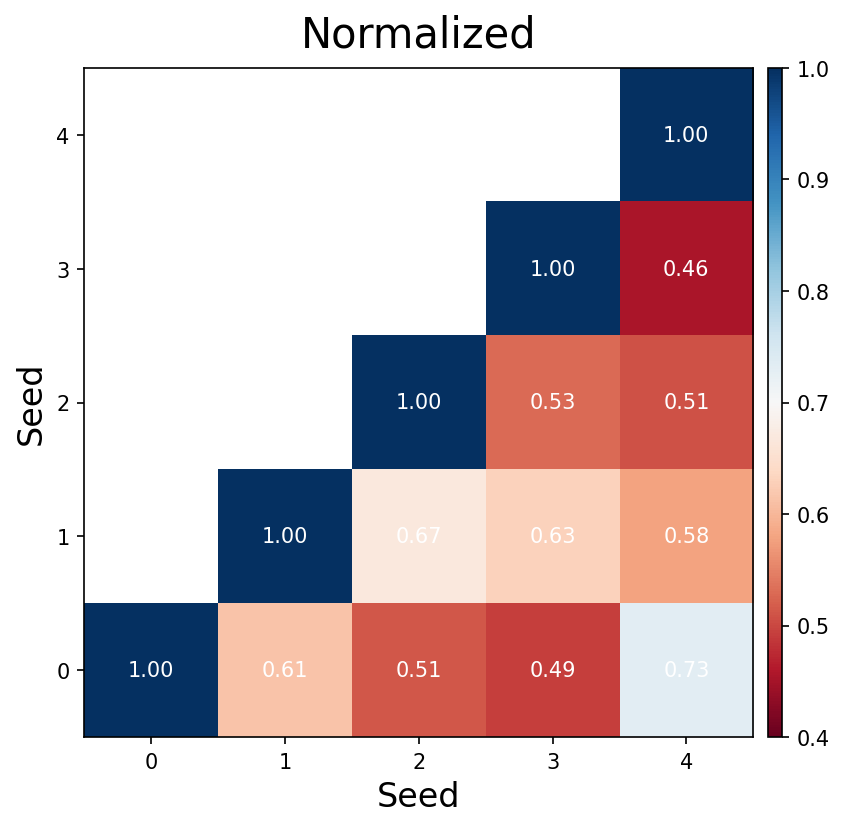

In [21]:
# RQ5, bert, normalized

# initialize
results = np.empty((5, 5))

# masking the upper triangle
results[:] = np.NaN

# the prior does not help!
for i in range(5):
    for j in range(i, 5):
        results[i,j] = pearsonr(n_berts_vec[i], n_berts_vec[j])[0]

# plot
fig, ax = plt.subplots(figsize=(6,6), dpi=150)

cmap = copy.copy(matplotlib.cm.get_cmap("RdBu"))
cmap.set_bad('white', 1.)

heatmap = ax.imshow(results, cmap=cmap, origin='lower', vmin=0.4, vmax=1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.1)

fig.colorbar(heatmap, cax = cax)

# text annotation
for i in range(5):
    for j in range(i, 5):
        text = ax.text(j, i, f'{results[i, j]:.2f}',
                       ha="center", va="center", color="w")

ax.set_title(f"Normalized", fontsize=20, pad=10)
ax.set_xlabel("Seed", fontsize=16)
ax.set_ylabel("Seed", fontsize=16)

plt.savefig(f'{fig_root}/RQ5-bert-{save_template}-k{k_bert}-normalized.pdf', bbox_inches='tight')
plt.show()

In [22]:
# pairwise correlation of the last step of BERTs

for i in range(5):
    for j in range(5):
        print(pearsonr(N_berts[i][-1], N_berts[j][-1])[0])

1.0
0.5404144273046126
0.4505114325738801
0.4762166273609903
0.5062937234215696
0.5404144273046126
1.0
0.5689842651779307
0.5546587974969873
0.471785162553794
0.4505114325738801
0.5689842651779307
1.0
0.47810119501931536
0.48087307788389716
0.4762166273609903
0.5546587974969873
0.47810119501931536
1.0
0.4059727287049937
0.5062937234215696
0.471785162553794
0.48087307788389716
0.4059727287049937
0.9999999999999999


## Appendix: Professions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


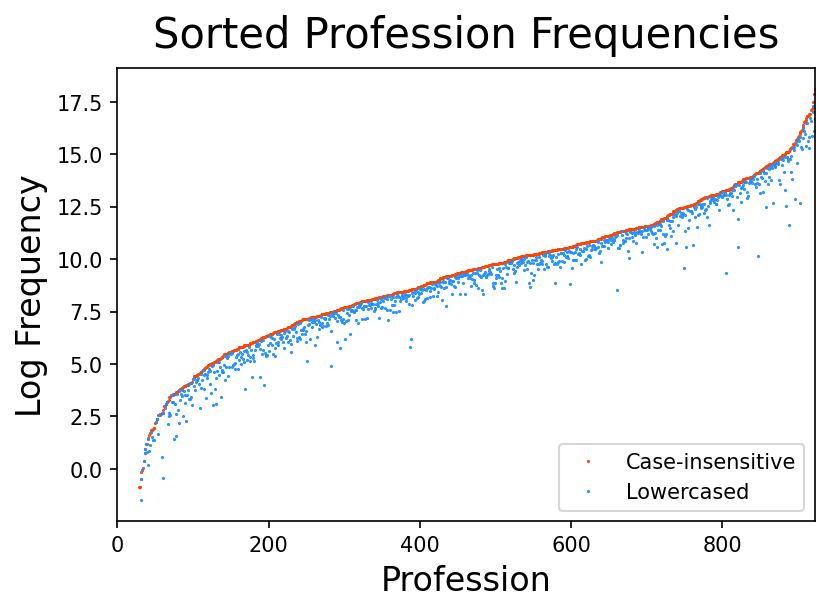

In [23]:
# do not sort in place

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

ax.plot(np.log(f_vec[np.argsort(f_vec)]), label = 'Case-insensitive',
        c = 'orangered', linestyle = 'None', marker='.', markersize=1)
ax.plot(np.log(f_vec_lower[np.argsort(f_vec)]), label = 'Lowercased',
        c = 'dodgerblue', linestyle = 'None', marker='.', markersize=1)

ax.set_title(f"Sorted Profession Frequencies", fontsize=20, pad=10)
ax.set_xlabel("Profession", fontsize=16)
ax.set_ylabel("Log Frequency", fontsize=16)

ax.set_xlim(0, 922)

ax.legend(loc='lower right')

plt.savefig(f'{fig_root}/profession-frequencies.pdf', bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


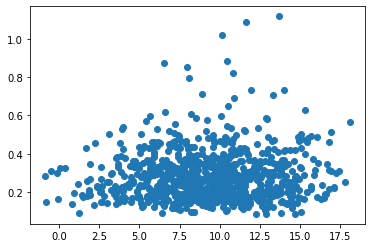

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


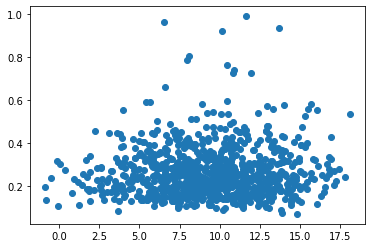

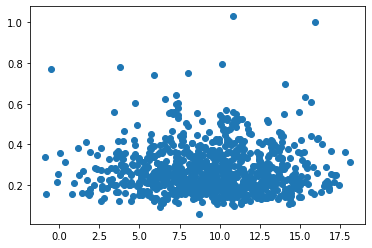

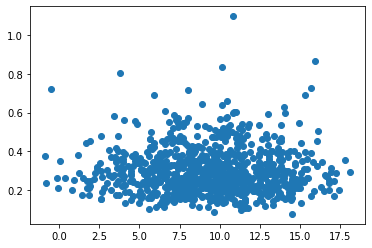

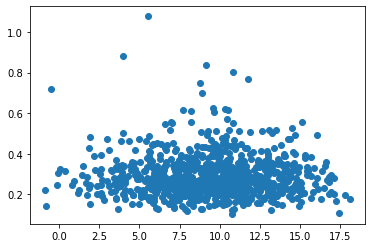

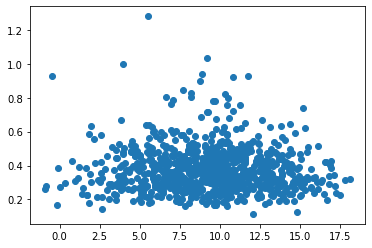

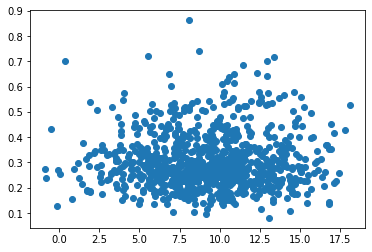

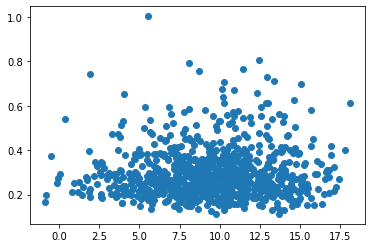

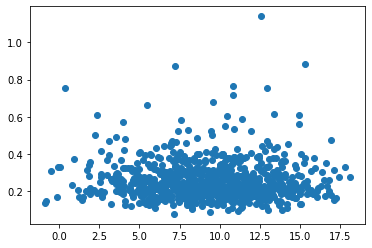

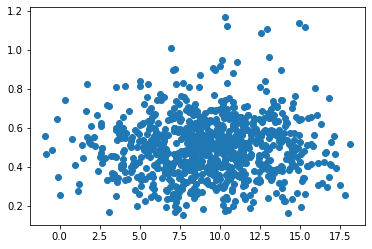

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


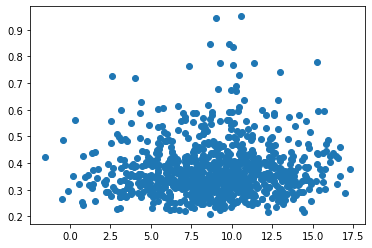

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


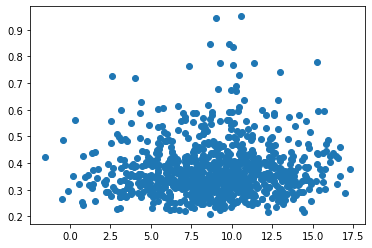

In [24]:
# only double-check RQ3, plots not saved or properly formatted

# bert
for seed in seeds:
    # unnormalized
    plt.scatter(np.log(np.sort(f_vec)), v_berts_R_vec[seed])
    plt.show()

    # normalized
    plt.scatter(np.log(np.sort(f_vec)), v_berts_N_vec[seed])
    plt.show()

# roberta

# unnormalized
plt.scatter(np.log(np.sort(f_vec_lower)), v_roberta_R_vec)
plt.show()

# normalized
plt.scatter(np.log(np.sort(f_vec_lower)), v_roberta_R_vec)
plt.show()